In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
C1 = 10e-9   # 10nF
C2 = 100e-9  # 100nF

# Chua Diode
R1 = 220
R2 = 220
R3 = 2200
R4 = 22000
R5 = 22000
R6 = 3300

R7 = 100  # 100 Ohms
R8 = 3300  # 1k Ohms
R9 = 1000  # 1k Ohms
C = 100e-9  # 100nF

def RealChua(t, inp, R, R10):
    G = 1 / R
    x = inp[0]  # v_1
    y = inp[1]  # v_2
    z = inp[2]  # i_L

    Esat = 10    # 9V batteries
    E1 = R3 / (R2 + R3) * Esat
    E2 = R6 / (R5 + R6) * Esat

    m12 = -1 / R6
    m02 = 1 / R4
    m01 = 1 / R1
    m11 = -1 / R3

    m1 = m12 + m11

    if E1 > E2:
        m0 = m11 + m02
    else:
        m0 = m12 + m01

    mm1 = m01 + m02
    Emax = max(E1, E2)
    Emin = min(E1, E2)

    if abs(x) < Emin:
        g = x * m1
    elif abs(x) < Emax:
        g = x * m0
        if x > 0:
            g += Emin * (m1 - m0)
        else:
            g += Emin * (m0 - m1)
    else:  # abs(x) >= Emax
        g = x * mm1
        if x > 0:
            g += Emax * (m0 - mm1) + Emin * (m1 - m0)
        else:
            g += Emax * (mm1 - m0) + Emin * (m0 - m1)
    L = R7 * R9 * C * R10 / R8  # 18mH

    # Chua's Circuit Equations
    xdot = (1 / C1) * (G * (y - x) - g)
    ydot = (1 / C2) * (G * (x - y) + z)
    zdot = -(1 / L) * y

    return np.array([xdot, ydot, zdot])

In [37]:
initial_conditions = np.array([0.001, 0.001, 0.])  # Начальные условия
t_span = (0, 0.01)

results = []
values = {}

idx = 0
for R in tqdm(np.linspace(0.1, 2.2, 10)):
    for R10 in (np.linspace(0.01, 10, 20)):
        values[idx] = (round(R, 1), round(R10, 1))
        
        solution = solve_ivp(lambda t, inp: RealChua(t, inp, R*1000, R10*1000), t_span, initial_conditions, method='LSODA')
        results.append([solution.y[0], solution.y[1]])
        
        idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

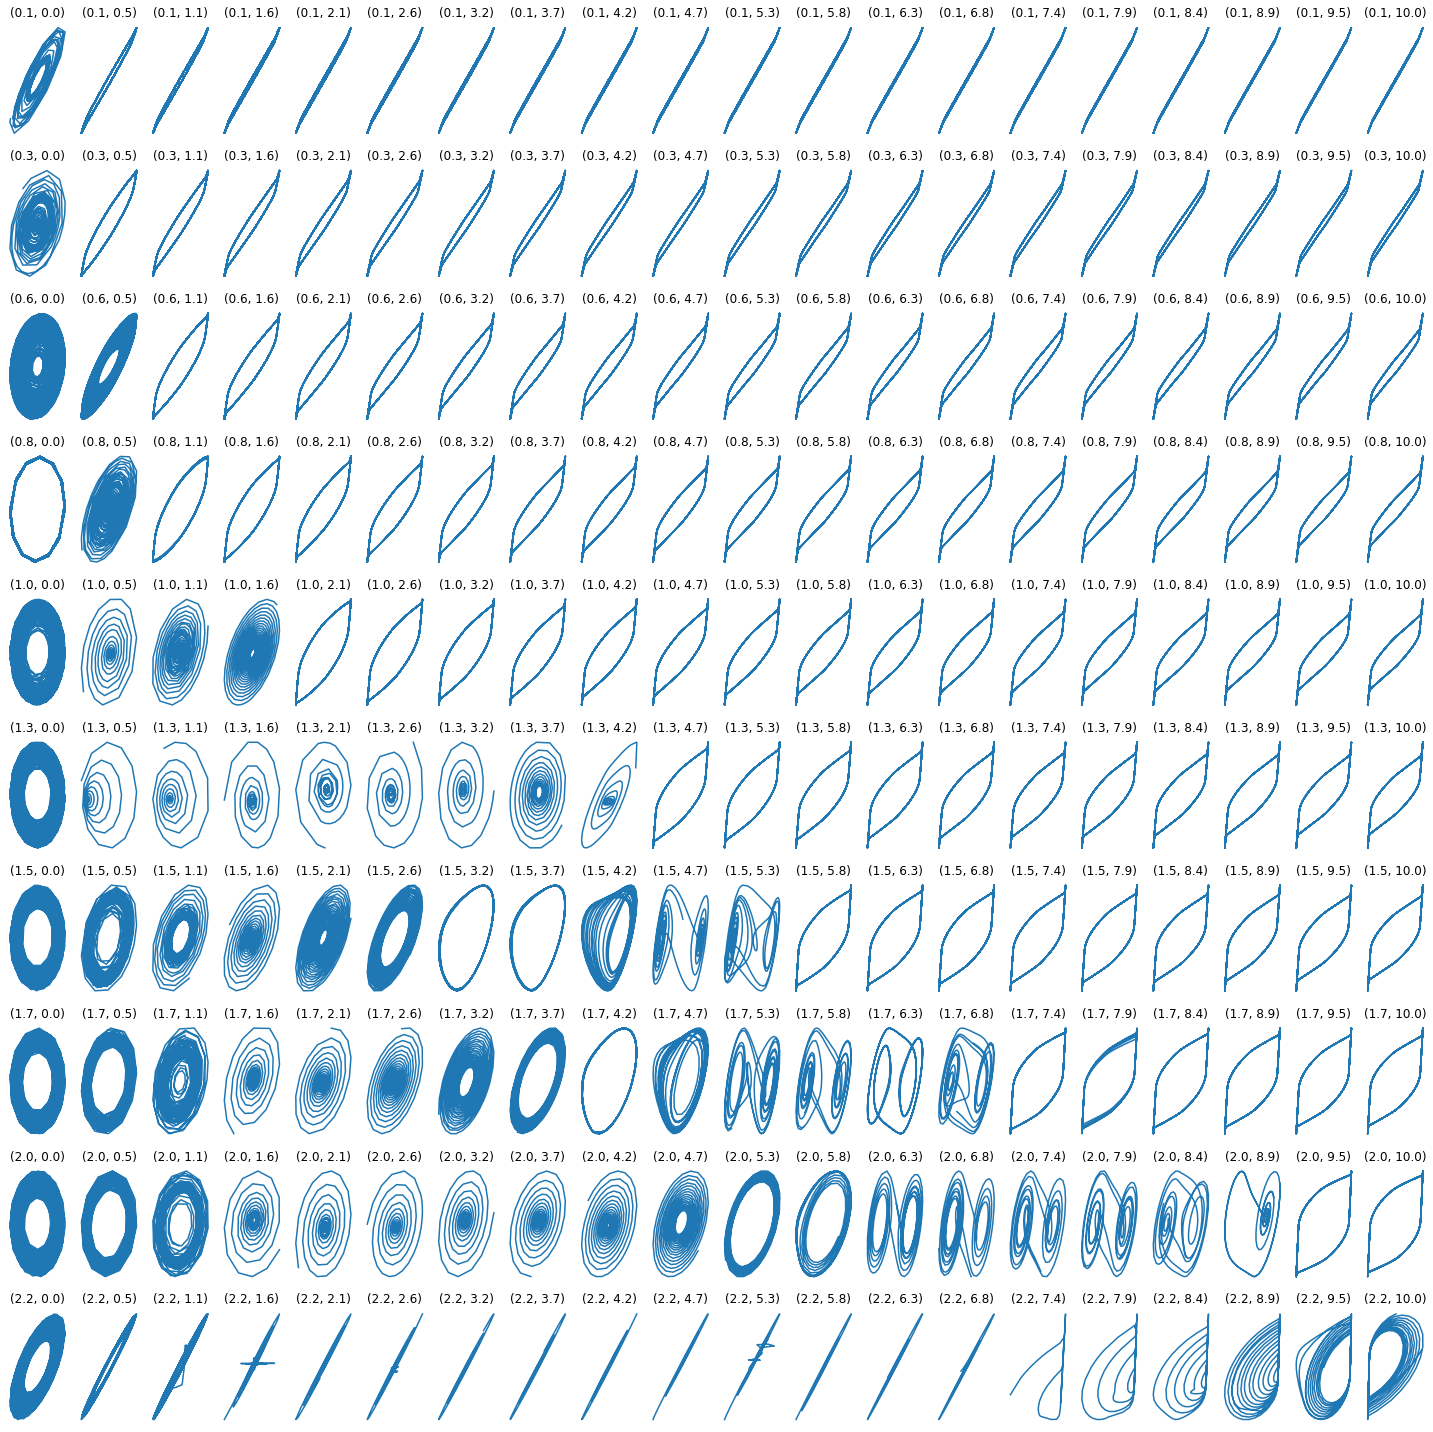

In [38]:
fig, axs = plt.subplots(10, 20, figsize=(20, 20))

for idx, ax in enumerate(axs.flat):
    x, y = results[idx]
    x = x[len(x) // 2:]
    y = y[len(y) // 2:]
    
    ax.plot(x, y)
    ax.axis('off')
    ax.set_title(f'{values[idx]}')

plt.tight_layout()